In [18]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
df = df.drop(columns=['volume','change', 'low', 'high', 'open'])
df = df.rename(columns={"value": "wallets"})
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
df['walletL'] = np.log(df['wallets'])
#https://dcresearch.medium.com/metcalfes-law-and-bitcoin-s-value-2b99c7efd1fa

In [19]:
df['Metcafe']=df['address']**2
# df["Metcafe"] = df["Metcafe"].map("{:.1f}".format)
df['value'] = df['Metcafe']/df['mined']
df["value"] = df["value"].map("{:.2f}".format)
df['value']=df['value'].astype("float")
df['networkvalue'] = df["price"] - df["value"]

In [20]:
df_train = df[['date', 'wallets']]
df_train = df_train.rename(columns = {"date":"ds", "wallets":"y"})
df_train.to_csv('../Resources/mlwalletsdata.csv')

m = Prophet()
m.fit(df_train)

n_years =2
period = n_years * 365
future = m.make_future_dataframe(periods = period)
forecast = m.predict(future)

21:21:05 - cmdstanpy - INFO - Chain [1] start processing
21:21:09 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5111,2024-10-20,18.778342,13.155958,24.520337
5112,2024-10-21,18.779451,13.176709,24.575060
5113,2024-10-22,18.783043,13.121813,24.571853
5114,2024-10-23,18.784634,13.123865,24.659978
5115,2024-10-24,18.786024,12.995504,24.650438


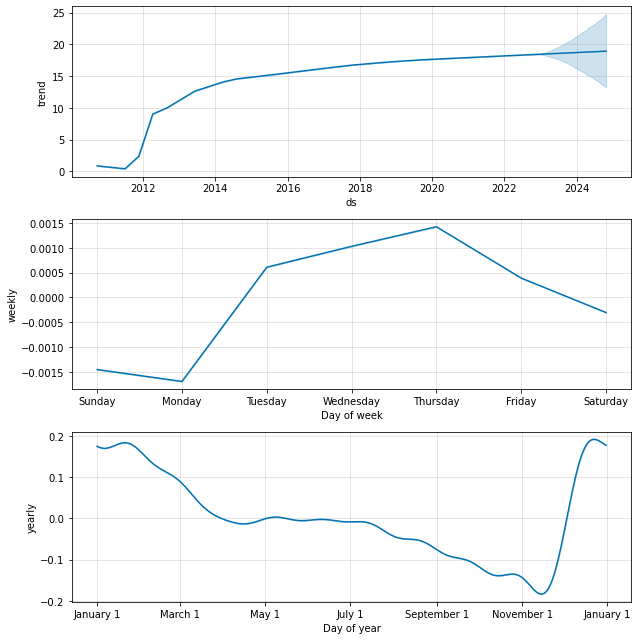

In [5]:
fig2 = m.plot_components(forecast)

In [6]:
df_train = df[['date', 'walletL']]
df_train = df_train.rename(columns = {"date":"ds", "walletL":"y"})

m = Prophet()
m.fit(df_train)

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

20:37:02 - cmdstanpy - INFO - Chain [1] start processing
20:37:11 - cmdstanpy - INFO - Chain [1] done processing
20:37:11 - cmdstanpy - INFO - Chain [1] start processing
20:37:16 - cmdstanpy - INFO - Chain [1] done processing


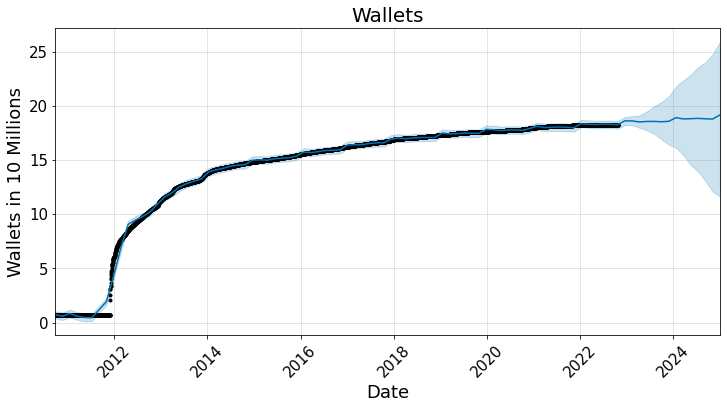

In [7]:
# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2010-09-25", "2024-12-31", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("Wallets", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Wallets in 10 Millions", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2010-09-25', '2024-12-31'])) 
plt.show();
# plt.savefig("../static/wallets.png")

In [17]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(name="Actual", x=df['date'], y=df['wallets'], legendrank=4))
fig.add_trace(go.Scatter(name="Middle Bound Prediction", x=prediction['ds'], y=np.exp(prediction['yhat']), legendrank=2))
fig.add_trace(go.Scatter(name="Lower Bound Prediction", x=prediction['ds'], y=np.exp(prediction['yhat_lower']), legendrank=1))
fig.add_trace(go.Scatter(name="Upper Bound Prediction", x=prediction['ds'], y=np.exp(prediction['yhat_upper']), legendrank=1))

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)

# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=0.99,
#     xanchor="right",
#     x=0.5
# ))
fig.update_yaxes(type="log")
fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Wallets and Date Prediction')
fig.update_yaxes(ticklabelposition="inside top", title="Bitcoin Wallets")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=20)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.layout.template = 'seaborn'
fig.show()
# fig.write_html('../static/wallets.html')

In [9]:
metric_df = forecast.set_index('ds')[['yhat']].join(df_train.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

In [10]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print(r2_score(metric_df.y, metric_df.yhat))
print(mean_squared_error(metric_df.y, metric_df.yhat))
print(mean_absolute_error(metric_df.y, metric_df.yhat))

0.9972290075144511
0.07416128800970026
0.13258390061590286
